## Purpose:
This notebook performs an empirical analysis of unicorn startups using the `ramjasmaurya/unicorn-startups` dataset. The primary goal is to extract insights into the dynamics of high-growth entrepreneurial ventures, providing a data-driven perspective on factors contributing to their success.

This analysis directly addresses key research themes central to the Mærsk Mc-Kinney Møller Endowed Chair of Entrepreneurship, offering valuable quantitative evidence for understanding entrepreneurial ecosystems:

1.  **Resource Attraction**: By examining the 'Investors' data, this notebook will identify prominent venture capital firms and investment trends, shedding light on how unicorn startups secure crucial funding. This analysis contributes to understanding the mechanisms of capital acquisition, investor networks, and the signaling effects of early-stage funding in high-growth ventures.

2.  **Growth Strategies**: The analysis of 'Date Joined' and 'Country' data will reveal temporal and geographical patterns in unicorn emergence. Investigate annual growth trends, identify regions with high unicorn density, and potentially uncover early indicators of market maturity or emerging entrepreneurial hubs. This provides insights into effective scaling strategies and environmental factors fostering rapid growth.

3.  **Industry Trends**: Through a detailed examination of the 'Industry' column, pinpoint which sectors are most conducive to fostering unicorn startups. Quantifying industry prevalence and growth to better understand the technological and market shifts driving innovation and capital allocation, informing strategies for new venture creation and industry development.


In [16]:
import kagglehub
import pandas as pd
import os
import re
import ast
import matplotlib.pyplot as plt

In [17]:
# Download latest version
path = kagglehub.dataset_download("ramjasmaurya/unicorn-startups")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'unicorn-startups' dataset.
Path to dataset files: /kaggle/input/unicorn-startups


In [18]:
# 1. Locate the file in the downloaded path
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
full_path = os.path.join(path, csv_file)


In [19]:

# 2. Load the dataset
df = pd.read_csv(full_path)


In [20]:
df.head()

,Company,Valuation ($B),Date Joined,Country,City,Industry,Investors
0,ByteDance,$140,4/7/2017,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S..."
1,SpaceX,$127,12/1/2012,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen..."
2,SHEIN,$100,7/3/2018,China,Shenzhen,E-commerce & direct-to-consumer,"Tiger Global Management, Sequoia Capital China..."
3,Stripe,$95,1/23/2014,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG"
4,Canva,$40,1/8/2018,Australia,Surry Hills,Internet software & services,"Sequoia Capital China, Blackbird Ventures, Mat..."


In [21]:
# 3. Clean column names and rename valuation specifically
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Rename the 'valuation' column
df = df.rename(columns={'valuation_($b)': 'valuation_billions'})

# Clean the data: Remove '$' and 'B', then convert to float
# This transforms "$180B" into 180.0
df['valuation_billions'] = (
    df['valuation_billions']
    .replace({'\$': '', 'B': ''}, regex=True)
    .astype(float)
)

print(df[['company', 'valuation_billions']].head())

     company  valuation_billions
0  ByteDance               140.0
1     SpaceX               127.0
2      SHEIN               100.0
3     Stripe                95.0
4      Canva                40.0


<>:11: SyntaxWarning: invalid escape sequence '\$'
<>:11: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-1450725740.py:11: SyntaxWarning: invalid escape sequence '\$'
  .replace({'\$': '', 'B': ''}, regex=True)


In [22]:
df.head()
# Check the type of the first entry to confirm it's type
print(type(df['industry'].iloc[0]))

<class 'str'>


In [23]:
df.head()
# Check the type of the first entry to confirm it's type
print(type(df['investors'].iloc[0]))

<class 'str'>


In [24]:
# 1. Convert the string representation of a list into an actual list
def force_list(val):
    # If it's already a list, clean its elements and return (handle this first)
    if isinstance(val, list):
        # Ensure sub_items are strings before stripping, and filter out empty ones
        cleaned_list = [str(item).strip() for item in val if item is not None and str(item).strip()]
        return sorted(list(set(cleaned_list))) # Remove duplicates and sort

    # Handle NaN values for non-list inputs
    if pd.isna(val):
        return []

    # Now 'val' must be a string (or something ast.literal_eval can handle)
    val_str = str(val)

    processed_items = []
    try:
        # Try to evaluate as a Python literal (e.g., "['A', 'B']" or "Fintech")
        evaluated = ast.literal_eval(val_str)
        if isinstance(evaluated, list):
            # If it evaluates to a list, extend with its cleaned elements
            processed_items.extend([sub_item.strip() for sub_item in evaluated if sub_item and str(sub_item).strip()])
        else:
            # If it evaluates to a single item (e.g., "Fintech"), treat it as a comma-separated string
            processed_items.extend([sub_item.strip() for sub_item in str(evaluated).split(',') if sub_item and str(sub_item).strip()])
    except (ValueError, SyntaxError):
        # If not a literal list or single literal, treat as a plain comma-separated string
        processed_items.extend([sub_item.strip() for sub_item in val_str.split(',') if sub_item and str(sub_item).strip()])

    # Remove duplicates, ensure no empty strings from processing, then sort
    unique_cleaned_items = [item for item in sorted(list(set(processed_items))) if item]
    return unique_cleaned_items

df['industry'] = df['industry'].apply(force_list)
df['investors'] = df['investors'].apply(force_list)

# 2. Verify again - this should now say <class 'list'>
print(f"New Type: {type(df['industry'].iloc[0])}")

# 3. Now the count will work perfectly
industry_counts = df.explode('industry')['industry'].value_counts()
print(industry_counts.head(100))

#It looks like I am still pulling investors into the industry column and need to figure

New Type: <class 'list'>
industry
Fintech                            239
Internet software & services       224
E-commerce & direct-to-consumer    103
Health                              94
Artificial intelligence             74
                                  ... 
Dynamic Parcel Distribution          1
Monk's Hill Ventures                 1
Guggenheim Investments               1
Qatar Investment Authority           1
Temasek                              1
Name: count, Length: 64, dtype: int64


In [25]:
investor_counts = df.explode

In [26]:
# 1. Convert 'date_joined' to datetime format
# This allows us to use .dt accessories like .dt.year
df['date_joined'] = pd.to_datetime(df['date_joined'], errors='coerce')

# 2. Define our "Last 3 Years" window
# Assuming today is early 2026
recent_unicorns = df[df['date_joined'] >= '2023-01-01']

# 3. Group by country and count
growth_by_country = (
    recent_unicorns.groupby('country')['company']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

print("Top 10 Countries by New Unicorns (2023-2026):")
print(growth_by_country)

Top 10 Countries by New Unicorns (2023-2026):
Series([], Name: company, dtype: int64)


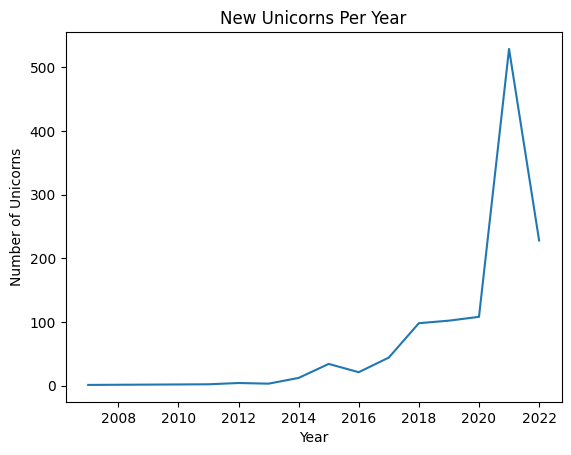

In [27]:
# Group by year and count companies, then plot
df.groupby(df['date_joined'].dt.year)['company'].count().plot(kind='line', title='New Unicorns Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Unicorns')
plt.show()

In [28]:
# 1. Explode the lists into individual rows
# 2. Get the unique values from that resulting series
# 3. Sort them alphabetically for easier reading
unique_industries = sorted(df.explode('industry')['industry'].unique())

print(f"There are {len(unique_industries)} unique industries:")
print(unique_industries)

#same issue will need more time with this data

There are 64 unique industries:
['& delivery', '500 Global', 'Accel', 'Activant Capital', 'Alibaba Entrepreneurs Fund', 'Alpha JWC Ventures', 'Andreessen Horowitz', 'Artificial Intelligence', 'Artificial intelligence', 'Auto & transportation', 'B Capital Group', 'Boyu Capital', 'Consumer & retail', 'Cybersecurity', 'DC Thomson Ventures', 'DCM Ventures', 'DST Global', 'Data management & analytics', 'Doqling Capital Partners', 'Dragonfly Captial', 'Dynamic Parcel Distribution', 'E-commerce & direct-to-consumer', 'Edtech', 'Fintech', 'GIC. Apis Partners', 'GSR Ventures', 'Global Founders Capital', 'Golden Gate Ventures', 'Guggenheim Investments', 'Hardware', 'Health', 'Hopu Investment Management', 'IDG Capital', 'ING', 'Insight Partners', 'Internet', 'Internet software & services', 'Jungle Ventures', 'Kuang-Chi', 'Mobile & telecommunications', "Monk's Hill Ventures", 'Mundi Ventures', 'Other', 'Qatar Investment Authority', 'Qiming Venture Partners', 'Qualgro', 'Rakuten Ventures', 'Sequoia

In [29]:
# Explode the investors column and count them up
investor_counts = df.explode('investors')['investors'].value_counts()

print("Top 10 Investors by Unicorn Count:")
print(investor_counts.head(25))

Top 10 Investors by Unicorn Count:
investors
Accel                               62
Andreessen Horowitz                 58
Tiger Global Management             56
Insight Partners                    55
Sequoia Capital                     52
Sequoia Capital China               46
General Catalyst                    42
Lightspeed Venture Partners         40
SoftBank Group                      35
Index Ventures                      33
Tencent Holdings                    31
General Atlantic                    30
Bessemer Venture Partners           28
Google Ventures                     27
Sequoia Capital India               26
IDG Capital                         26
New Enterprise Associates           25
Kleiner Perkins Caufield & Byers    23
Coatue Management                   23
Y Combinator                        23
Khosla Ventures                     22
DST Global                          19
Founders Fund                       19
Battery Ventures                    18
Goldman Sachs      

In [30]:
# 1. Explode the industry column (this creates a row for every item in the lists)
# 2. Use value_counts() to count the frequency of each unique industry
industry_counts = df.explode('industry')['industry'].value_counts()

print("Number of Unicorns per Industry:")
print(industry_counts.head(19))

Number of Unicorns per Industry:
industry
Fintech                            239
Internet software & services       224
E-commerce & direct-to-consumer    103
Health                              94
Artificial intelligence             74
Other                               65
Supply chain                        65
& delivery                          65
logistics                           65
Cybersecurity                       58
Data management & analytics         45
Auto & transportation               40
Hardware                            38
Mobile & telecommunications         37
Edtech                              32
Consumer & retail                   28
Travel                              14
Artificial Intelligence             11
Internet                             2
Name: count, dtype: int64
